In [ ]:
!pip install google-cloud-bigquery[pandas]
!pip install evaluation
!pip install keras
!pip install shap
!pip install google-cloud-storage
!pip install scikit-surprise

In [51]:
!pip show evaluation

Name: evaluation
Version: 0.0.2
Summary: 
Home-page: https://github.com/smarsu/compare
Author: smarsu
Author-email: smarsu@foxmail.com
License: 
Location: /opt/conda/lib/python3.7/site-packages
Requires: glog, numpy
Required-by: 


In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import numpy as np
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error
import evaluation
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] =  'tcloud-ga.json'
bq_client = bigquery.Client()

模型開始

In [2]:
sql_query1 ="""
with orderinfo as(
SELECT sme_ban, sum(sol_price) as total_pay, sum(sol_point) as pointsused , sum(sol_selfpay) as selfpay, sum(solution_duration) servicelen, count(order_num) as ordernums, solution_uuid FROM `tcloud-data-analysis.highly_use_data.orders` 
group by sme_ban,solution_uuid 
),
sme as (
  select * from tcloud-data-analysis.ml_data.sme_basic_numeric
),
page as (
  select * from `tcloud-data-analysis.ga3.solution_pv`
),
ind as (
  select sme_ban, ind_large from `tcloud-data-analysis.tcloud_analytics_iii.sme_basic`
)

select orderinfo.* , sme.* EXCEPT(sme_ban), page.* EXCEPT(clean_path2), ind_large
from orderinfo
join sme on orderinfo.sme_ban = sme.sme_ban
join page on orderinfo.solution_uuid = page.clean_path2
join ind on orderinfo.sme_ban= ind.sme_ban
"""
query_job1 = bq_client.query(sql_query1)
recommend = query_job1.to_dataframe()

In [3]:

query_indnm = """
SELECT * FROM `tcloud-data-analysis.tcloud_analytics_iii.industry_large`
"""

# 查詢資料並將結果存為 DataFrame
query_job = bq_client.query(query_indnm)
industry_df = query_job.to_dataframe()

# 提取所有可能的 ind_large 選項
ind_large_values = industry_df['ind_large'].unique()


query_subcate = """
SELECT * FROM `tcloud-data-analysis.tcloud_analytics_iii.solution_subcategory_encoding`
"""

# 查詢資料並將結果存為 DataFrame
query_job = bq_client.query(query_subcate)
solution_sub = query_job.to_dataframe()

In [4]:
import pandas as pd
from pandas.api.types import CategoricalDtype

# 將 ind_large 轉換為 CategoricalDtype 並指定所有可能的類別
ind_large_type = CategoricalDtype(categories=ind_large_values, ordered=False)
recommend['ind_large'] = recommend['ind_large'].astype(ind_large_type)

# 進行 one-hot encoding
ind_large_dummies = pd.get_dummies(recommend['ind_large'], prefix='ind_large')

# 將所有編碼列轉換為 'Int64' 數據類型
ind_large_dummies = ind_large_dummies.astype('Int64')

# 合併原始 DataFrame 和編碼後的 DataFrame
recommend = pd.concat([recommend.drop('ind_large', axis=1), ind_large_dummies], axis=1)


In [4]:
recommend = recommend.merge(solution_sub, on='solution_uuid', how='left')

In [5]:
recommend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47186 entries, 0 to 47185
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   sme_ban                                 47186 non-null  object
 1   total_pay                               47186 non-null  Int64 
 2   pointsused                              47186 non-null  Int64 
 3   selfpay                                 47186 non-null  Int64 
 4   servicelen                              47186 non-null  Int64 
 5   ordernums                               47186 non-null  Int64 
 6   solution_uuid                           47186 non-null  object
 7   q_organizationsize_level                47186 non-null  Int64 
 8   q_planningtime_level                    47186 non-null  Int64 
 9   q_budget_level                          47186 non-null  Int64 
 10  opscore1                                47186 non-null  object
 11  op

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ...其他程式碼(資料讀取等)...

def create_mappings(df, user_col, item_col):
    user_mapping = {user: idx for idx, user in enumerate(df[user_col].unique())}
    item_mapping = {item: idx for idx, item in enumerate(df[item_col].unique())}
    return user_mapping, item_mapping

def encode_data(df, user_col, item_col, user_mapping, item_mapping):
    df[user_col] = df[user_col].map(user_mapping)
    df[item_col] = df[item_col].map(item_mapping)
    return df

def reverse_mappings(mapping):
    return {idx: key for key, idx in mapping.items()}

def save_mappings(user_reverse_mapping, item_reverse_mapping, user_mapping_filename, item_mapping_filename):
    user_reverse_mapping_df = pd.DataFrame(list(user_reverse_mapping.items()), columns=['encoded', 'original'])
    item_reverse_mapping_df = pd.DataFrame(list(item_reverse_mapping.items()), columns=['encoded', 'original'])
    user_reverse_mapping_df.to_csv(user_mapping_filename, index=False)
    item_reverse_mapping_df.to_csv(item_mapping_filename, index=False)

sme_ban_mapping, solution_uuid_mapping = create_mappings(recommend, 'sme_ban', 'solution_uuid')

recommend_encoded = encode_data(recommend.copy(), 'sme_ban', 'solution_uuid', sme_ban_mapping, solution_uuid_mapping)

sme_ban_reverse_mapping = reverse_mappings(sme_ban_mapping)
solution_uuid_reverse_mapping = reverse_mappings(solution_uuid_mapping)

save_mappings(sme_ban_reverse_mapping, solution_uuid_reverse_mapping, 'sme_ban_reverse_mapping.csv', 'solution_uuid_reverse_mapping.csv')

# 數據分割
train_data, test_data = train_test_split(recommend_encoded, test_size=0.2, random_state=42)
# 欄位分割
sme_ban_columns = [
    'q_organizationsize_level', 'q_planningtime_level', 'q_budget_level',
    'opscore1', 'opscore2', 'marscore1', 'marscore2', 'salescore1', 'salescore2',
    'securscore1', 'securscore2', 'remotescore1', 'remotescore2', 'schedscore1',
    'schedscore2', 'sme_age', 'capital', 'employee_count',
    'ind_large_A', 'ind_large_B', 'ind_large_C', 'ind_large_D',
    'ind_large_E', 'ind_large_F', 'ind_large_G', 'ind_large_H',
    'ind_large_I', 'ind_large_J', 'ind_large_K', 'ind_large_L',
    'ind_large_M', 'ind_large_N', 'ind_large_P', 'ind_large_Q',
    'ind_large_R', 'ind_large_S'
]

solution_uuid_columns = [
    'pageview', 'bound', 'in_site', 'crm_system', 'erp_system', 'pos_integration', 'seo',
    'hr_management', 'credit_card_ticketing', 'survey_analysis',
    'big_data_analysis', 'customer_interaction', 'market_research',
    'digital_advertising', 'document_processing_software',
    'membership_point_system', 'production_logistics_management',
    'carbon_emission_calculation_analysis',
    'community_content_management_operation', 'sms_system',
    'online_customer_service', 'online_meeting', 'online_reservation',
    'energy_management_system', 'mobile_payment',
    'marketing_matchmaking_kol', 'financial_management',
    'information_security', 'public_opinion_analysis',
    'inventory_management_system', 'remote_collaboration',
    'antivirus_software', 'ecommerce_online_shopping_platform',
    'enewsletter_edm', 'electronic_invoice'
]
interaction_columns = ['total_pay']

# 將訓練集和測試集拆分為用戶編碼、物品編碼和交互作用
train_sme_ban = train_data['sme_ban'].astype('int32')
train_solution_uuid = train_data['solution_uuid'].astype('int32')
train_interactions = train_data[interaction_columns].astype('int32')

test_sme_ban = test_data['sme_ban'].astype('int32')
test_solution_uuid = test_data['solution_uuid'].astype('int32')
test_interactions = test_data[interaction_columns].astype('int32')





In [10]:
recommend_encoded

,sme_ban,total_pay,pointsused,selfpay,servicelen,ordernums,solution_uuid,q_organizationsize_level,q_planningtime_level,q_budget_level,...,marketing_matchmaking_kol,financial_management,information_security,public_opinion_analysis,inventory_management_system,remote_collaboration,antivirus_software,ecommerce_online_shopping_platform,enewsletter_edm,electronic_invoice
0,0,60000,30000,30000,6,1,0,2,1,2,...,0,0,0,0,0,0,0,1,0,0
1,1,37800,15000,22800,12,1,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
2,1,30000,15000,15000,12,1,2,1,2,1,...,0,0,0,0,0,0,0,0,0,0
3,2,60000,30000,30000,4,1,3,1,1,2,...,0,1,0,0,1,0,0,0,0,0
4,3,40068,20034,20034,12,1,4,1,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47181,37754,18000,14400,3600,12,1,1205,1,1,1,...,0,0,0,0,0,0,0,1,0,1
47182,23961,18000,14400,3600,12,1,1205,1,1,1,...,0,0,0,0,0,0,0,1,0,1
47183,30099,18000,14400,3600,12,1,1205,1,0,1,...,0,0,0,0,0,0,0,1,0,1
47184,23962,18000,14400,3600,12,1,1205,1,0,1,...,0,0,0,0,0,0,0,1,0,1


In [11]:
#interaction_columns = ['sme_ban', 'solution_uuid', 'total_pay', 'pointsused', 'selfpay', 'servicelen', 'ordernums']


# 分別獲取訓練集和測試集中的用戶和物品特徵
train_sme_ban_features = train_data[sme_ban_columns].astype('int32')
train_solution_uuid_features = train_data[solution_uuid_columns].astype('int32')

test_sme_ban_features = test_data[sme_ban_columns].astype('int32')
test_solution_uuid_features = test_data[solution_uuid_columns].astype('int32')


KeyError: "['ind_large_A', 'ind_large_B', 'ind_large_C', 'ind_large_D', 'ind_large_E', 'ind_large_F', 'ind_large_G', 'ind_large_H', 'ind_large_I', 'ind_large_J', 'ind_large_K', 'ind_large_L', 'ind_large_M', 'ind_large_N', 'ind_large_P', 'ind_large_Q', 'ind_large_R', 'ind_large_S'] not in index"

構建模型：創建一個基於深度神經協同過濾的推薦模型。該模型將接收用戶 ID、物品 ID 和相應的特徵作為輸入，並輸出預測消費總金額。


*   批次大小：32
*   密集層大小：(128, 64)
*   嵌入維度：16
*   清訓練周期：30
*   學習率：0.0005




---










In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 设置超参数
embedding_dim = 16
dense_layer_sizes = (128, 64)
learning_rate = 0.0005
epochs = 30
batch_size = 32

# SME_BAN 输入
sme_ban_input = Input(shape=(1,), name='sme_ban_input')
sme_ban_embedding = Embedding(input_dim=train_sme_ban.max() + 2, output_dim=embedding_dim, mask_zero=True, name='sme_ban_embedding')(sme_ban_input)
sme_ban_vec = Flatten()(sme_ban_embedding)

sme_ban_features_input = Input(shape=(len(sme_ban_columns),), name='sme_ban_features_input')
sme_ban_combined = Concatenate()([sme_ban_vec, sme_ban_features_input])

# Solution_UUID 输入
solution_uuid_input = Input(shape=(1,), name='solution_uuid_input')
solution_uuid_embedding = Embedding(input_dim=train_solution_uuid.max() + 2, output_dim=embedding_dim, mask_zero=True, name='solution_uuid_embedding')(solution_uuid_input)
solution_uuid_vec = Flatten()(solution_uuid_embedding)

solution_uuid_features_input = Input(shape=(len(solution_uuid_columns),), name='solution_uuid_features_input')
solution_uuid_combined = Concatenate()([solution_uuid_vec, solution_uuid_features_input])

# 将用户和物品组合在一起
combined = Concatenate()([sme_ban_combined, solution_uuid_combined])

# 添加全连接层
dense = Dense(dense_layer_sizes[0], activation='relu')(combined)
dense = Dense(dense_layer_sizes[1], activation='relu')(dense)

# 输出层：预测 total_pay
total_pay_output = Dense(1, activation='linear', name='total_pay_output')(dense)

# 创建模型
model = Model(inputs=[sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input], outputs=[total_pay_output])

# 编译模型
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# 训练模型
history = model.fit(
    [train_sme_ban, train_sme_ban_features, train_solution_uuid, train_solution_uuid_features],
    train_interactions,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
)


2023-05-14 13:47:01.210500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-14 13:47:01.210597: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-14 13:47:01.210635: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (recommend05): /proc/driver/nvidia/version does not exist
2023-05-14 13:47:01.211087: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0514 13:47:01.

Epoch 1/30
1047/1047 [==============================] - 8s 7ms/step - loss: 377373949952.0000 - val_loss: 85459697664.0000
Epoch 2/30
1047/1047 [==============================] - 7s 6ms/step - loss: 412497051648.0000 - val_loss: 2002549632.0000
Epoch 3/30
1047/1047 [==============================] - 7s 7ms/step - loss: 2297652736.0000 - val_loss: 64020930560.0000
Epoch 4/30
1047/1047 [==============================] - 7s 7ms/step - loss: 182029205504.0000 - val_loss: 2312194816.0000
Epoch 5/30
1047/1047 [==============================] - 7s 7ms/step - loss: 354490843136.0000 - val_loss: 2904817664.0000
Epoch 6/30
1047/1047 [==============================] - 7s 6ms/step - loss: 68259815424.0000 - val_loss: 1299276672.0000
Epoch 7/30
1047/1047 [==============================] - 7s 7ms/step - loss: 19048212480.0000 - val_loss: 53321736192.0000
Epoch 8/30
1047/1047 [==============================] - 7s 6ms/step - loss: 507252375552.0000 - val_loss: 1104308736.0000
Epoch 9/30
1047/1047 [===

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import time

start_time = time.time()
# 设置超参数
embedding_dim = 16
dense_layer_sizes = (128, 64)
learning_rate = 0.0005
epochs = 30
batch_size = 32

# Find the maximum possible SME_BAN and Solution_UUID
max_sme_ban = max(train_sme_ban.max(), 100000)
max_solution_uuid = max(train_solution_uuid.max(), 10000)

# SME_BAN 输入
sme_ban_input = Input(shape=(1,), name='sme_ban_input')
sme_ban_embedding = Embedding(input_dim=max_sme_ban + 1, output_dim=embedding_dim, mask_zero=True, name='sme_ban_embedding')(sme_ban_input)
sme_ban_vec = Flatten()(sme_ban_embedding)

sme_ban_features_input = Input(shape=(len(sme_ban_columns),), name='sme_ban_features_input')
sme_ban_combined = Concatenate()([sme_ban_vec, sme_ban_features_input])

# Solution_UUID 输入
solution_uuid_input = Input(shape=(1,), name='solution_uuid_input')
solution_uuid_embedding = Embedding(input_dim=max_solution_uuid + 1, output_dim=embedding_dim, mask_zero=True, name='solution_uuid_embedding')(solution_uuid_input)
solution_uuid_vec = Flatten()(solution_uuid_embedding)

solution_uuid_features_input = Input(shape=(len(solution_uuid_columns),), name='solution_uuid_features_input')
solution_uuid_combined = Concatenate()([solution_uuid_vec, solution_uuid_features_input])

# 将用户和物品组合在一起
combined = Concatenate()([sme_ban_combined, solution_uuid_combined])

# 添加全连接层
dense = Dense(dense_layer_sizes[0], activation='relu')(combined)
dense = Dense(dense_layer_sizes[1], activation='relu')(dense)

# 输出层：预测 total_pay
total_pay_output = Dense(1, activation='linear', name='total_pay_output')(dense)

# 创建模型
model = Model(inputs=[sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input], outputs=[total_pay_output])

# 编译模型
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# 训练模型
history = model.fit(
    [train_sme_ban, train_sme_ban_features, train_solution_uuid, train_solution_uuid_features],
    train_interactions,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
)

end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")

W0514 14:49:18.203691 20470 warnings.py:110] The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/30
1047/1047 [==============================] - 15s 14ms/step - loss: 1143816847360.0000 - val_loss: 3303623424.0000
Epoch 2/30
1047/1047 [==============================] - 15s 14ms/step - loss: 4941128192.0000 - val_loss: 1913805568.0000
Epoch 3/30
1047/1047 [==============================] - 14s 14ms/step - loss: 32554274816.0000 - val_loss: 1413802496.0000
Epoch 4/30
1047/1047 [==============================] - 15s 15ms/step - loss: 67765424128.0000 - val_loss: 2484467456.0000
Epoch 5/30
1047/1047 [==============================] - 14s 13ms/step - loss: 373424488448.0000 - val_loss: 21661853696.0000
Epoch 6/30
1047/1047 [==============================] - 14s 14ms/step - loss: 474496499712.0000 - val_loss: 14697469952.0000
Epoch 7/30
1047/1047 [==============================] - 14s 14ms/step - loss: 2253589248.0000 - val_loss: 12473454592.0000
Epoch 8/30
1047/1047 [==============================] - 15s 14ms/step - loss: 11149376512.0000 - val_loss: 955342464.0000
Epoch 9/30
1

In [69]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 设置超参数
embedding_dim = 16
dense_layer_sizes = (128, 64)
learning_rate = 0.0005
epochs = 30
batch_size = 32

# SME_BAN 输入
sme_ban_input = Input(shape=(1,), name='sme_ban_input')
sme_ban_embedding = Embedding(input_dim=train_sme_ban.max() + 2, output_dim=embedding_dim, mask_zero=True, name='sme_ban_embedding')(sme_ban_input)
sme_ban_vec = Flatten()(sme_ban_embedding)

sme_ban_features_input = Input(shape=(len(sme_ban_columns),), name='sme_ban_features_input')
sme_ban_combined = Concatenate()([sme_ban_vec, sme_ban_features_input])

# Solution_UUID 输入
solution_uuid_input = Input(shape=(1,), name='solution_uuid_input')
solution_uuid_embedding = Embedding(input_dim=train_solution_uuid.max() + 2, output_dim=embedding_dim, mask_zero=True, name='solution_uuid_embedding')(solution_uuid_input)
solution_uuid_vec = Flatten()(solution_uuid_embedding)

solution_uuid_features_input = Input(shape=(len(solution_uuid_columns),), name='solution_uuid_features_input')
solution_uuid_combined = Concatenate()([solution_uuid_vec, solution_uuid_features_input])

# 将用户和物品组合在一起
combined = Concatenate()([sme_ban_combined, solution_uuid_combined])

# 添加全连接层
dense = Dense(dense_layer_sizes[0], activation='relu')(combined)
dense = Dense(dense_layer_sizes[1], activation='relu')(dense)

# 输出层：预测 total_pay
total_pay_output = Dense(1, activation='linear', name='total_pay_output')(dense)

# 创建模型
model = Model(inputs=[sme_ban_input, sme_ban_features_input, solution_uuid_input, solution_uuid_features_input], outputs=[total_pay_output])

# 编译模型
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# 训练模型
history = model.fit(
    [train_sme_ban, train_sme_ban_features, train_solution_uuid, train_solution_uuid_features],
    train_interactions,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
)


W0516 02:57:19.466867 20470 warnings.py:110] The `lr` argument is deprecated, use `learning_rate` instead.



ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'pandas.core.arrays.integer.IntegerArray'>]

In [10]:
# 查看模型结构
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sme_ban_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 solution_uuid_input (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 sme_ban_embedding (Embedding)  (None, 1, 16)        1600016     ['sme_ban_input[0][0]']          
                                                                                                  
 solution_uuid_embedding (Embed  (None, 1, 16)       160016      ['solution_uuid_input[0][0]']

In [43]:
!pip freeze > requirements.txt



---



In [11]:
# 将 Keras 模型转换为 TensorFlow 模型
tf_model = tf.keras.models.Model.from_config(model.get_config())
tf_model.build(model.input_shape)

# 获取输入和输出张量的名称
input_tensor_names = []
output_tensor_names = []

for input_tensor in tf_model.inputs:
    input_tensor_names.append(input_tensor.name)
    
for output_tensor in tf_model.outputs:
    output_tensor_names.append(output_tensor.name)

# 输出张量名称
print("Input tensor names:", input_tensor_names)
print("Output tensor names:", output_tensor_names)

Input tensor names: ['sme_ban_input', 'sme_ban_features_input', 'solution_uuid_input', 'solution_uuid_features_input']
Output tensor names: ['total_pay_output/BiasAdd:0']




---



預測模組


In [12]:


# 從訓練集中選擇一組輸入
example_index = 0
example_sme_ban = np.array([train_sme_ban.iloc[example_index]])
example_sme_ban_features = train_sme_ban_features.iloc[[example_index]]
example_solution_uuid = np.array([train_solution_uuid.iloc[example_index]])
example_solution_uuid_features = train_solution_uuid_features.iloc[[example_index]]

# 使用模型進行預測
example_output = model.predict([example_sme_ban, example_sme_ban_features, example_solution_uuid, example_solution_uuid_features])
print(f"Example output: {example_output}")

def recommend_items_for_user(user_id, model, sme_ban_features, solution_uuid_features, top_n=5):
    # 從映射中找到用戶的編碼
    encoded_user_id = sme_ban_mapping[user_id]

    # 獲取已互動過的物品
    interacted_items_encoded = recommend_encoded[recommend_encoded['sme_ban'] == encoded_user_id]['solution_uuid'].unique()
    interacted_items = [solution_uuid_reverse_mapping[item] for item in interacted_items_encoded]

    # 找到未互動過的物品
    all_items = set(solution_uuid_mapping.keys())
    not_interacted_items = list(all_items - set(interacted_items))

    # 準備用於預測的輸入數據
    user_input = np.array([encoded_user_id] * len(not_interacted_items))
    not_interacted_items_encoded = [solution_uuid_mapping[item] for item in not_interacted_items]
    item_input = np.array(not_interacted_items_encoded)
    user_features_input = np.repeat(sme_ban_features.loc[encoded_user_id].values.reshape(1, -1), len(not_interacted_items), axis=0)
    item_features_input = solution_uuid_features.loc[not_interacted_items_encoded].values

    # 進行預測
    predictions = model.predict([user_input, user_features_input, item_input, item_features_input])

    # 獲取前 N 個物品的索引
    top_n_indices = predictions[:, 0].argsort()[-top_n:][::-1]

    # 獲取前 N 個物品的編碼
    top_n_items_encoded = item_input[top_n_indices]

    # 將物品編碼轉換為原始 UUID
    top_n_items = [solution_uuid_reverse_mapping[item] for item in top_n_items_encoded]

    return top_n_items

def prepare_new_user_input(user_features_df, num_items):
    # 檢查新用戶特徵是否具有正確的列順序
    if not all(user_features_df.columns == sme_ban_columns):
        raise ValueError("The columns of the new user features DataFrame must match the order of sme_ban_columns.")
    
    # 為新用戶分配一個編碼（可以選擇大於所有現有編碼的最大值的數字）
    new_user_encoded = max(sme_ban_mapping.values()) + 1

    # 準備輸入數據
    user_input = np.array([new_user_encoded] * num_items)
    user_features_input = np.repeat(user_features_df.values.reshape(1, -1), num_items, axis=0)

    return user_input, user_features_input



Example output: [[4792.734]]


In [13]:
# 假設以下是新用戶的特徵
new_user_features = pd.DataFrame([{
    'q_organizationsize_level': 3, 'q_planningtime_level': 2, 'q_budget_level': 1,
    'opscore1': 4, 'opscore2': 3, 'marscore1': 3, 'marscore2': 2, 'salescore1': 1, 'salescore2': 2,
    'securscore1': 2, 'securscore2': 3, 'remotescore1': 1, 'remotescore2': 2, 'schedscore1': 2,
    'schedscore2': 3, 'sme_age': 5, 'capital': 10000, 'employee_count': 50,
    'ind_large_A': 0, 'ind_large_B': 1, 'ind_large_C': 0, 'ind_large_D': 0,
    'ind_large_E': 0, 'ind_large_F': 0, 'ind_large_G': 0, 'ind_large_H': 0,
    'ind_large_I': 0, 'ind_large_J': 0, 'ind_large_K': 0, 'ind_large_L': 0,
    'ind_large_M': 0, 'ind_large_N': 0, 'ind_large_P': 0, 'ind_large_Q': 0,
    'ind_large_R': 0, 'ind_large_S': 0
}], columns=sme_ban_columns)
# 在這裡，我們使用所有物品進行預測
num_items = len(solution_uuid_mapping)

# 調用函數，為新用戶準備輸入數據
new_user_input, new_user_features_input = prepare_new_user_input(new_user_features, num_items)

# 選擇一個物品
example_item_index = 2
example_solution_uuid = np.array([train_solution_uuid.iloc[example_item_index]])
example_solution_uuid_features = train_solution_uuid_features.iloc[[example_item_index]]

# 使用函數為新用戶準備輸入數據
new_user_input, new_user_features_input = prepare_new_user_input(new_user_features, 1)

# 使用模型進行預測
example_output = model.predict([new_user_input, new_user_features_input, example_solution_uuid, example_solution_uuid_features])
print(f"Example output: {example_output}")


Example output: [[22926.785]]


In [67]:
print(new_user_input)
print(new_user_features_input)
print(example_solution_uuid)
print(example_solution_uuid_features)

[37215]
[[    3     2     1     4     3     3     2     1     2     2     3     1
      2     2     3     5 10000    50     0     1     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]
[227]
      pageview  bound  in_site  crm_system  erp_system  pos_integration  seo  \
6375      1305     99      189           0           1                1    0   

      hr_management  credit_card_ticketing  survey_analysis  ...  \
6375              0                      0                0  ...   

      marketing_matchmaking_kol  financial_management  information_security  \
6375                          0                     1                     0   

      public_opinion_analysis  inventory_management_system  \
6375                        0                            1   

      remote_collaboration  antivirus_software  \
6375                     0                   0   

      ecommerce_online_shopping_platform  enewsletter_edm  electronic_invoice  

In [14]:
# 获取所有上架产品的数据
sql_query2 = """
SELECT solution_uuid FROM `tcloud-data-analysis.tcloud_analytics_iii.solution_info` 
WHERE solution_status ='上架' AND solution_uuid IN (SELECT DISTINCT(solution_uuid) FROM tcloud-data-analysis.tcloud_analytics_iii.order_basic)
"""

query_job2 = bq_client.query(sql_query2)
on_shelf_solutions = query_job2.to_dataframe()
on_shelf_item_ids = on_shelf_solutions['solution_uuid'].tolist()
# 合并 train_solution_uuid_features 和 test_solution_uuid_features
all_solution_uuid_features = pd.concat([train_solution_uuid_features, test_solution_uuid_features], axis=0)


# 从所有数据集中提取已上架物品的特征
on_shelf_item_encoded = []
on_shelf_solution_uuid_features = all_solution_uuid_features.loc[on_shelf_item_encoded]

# 使用 solution_uuid_mapping 将 item id 映射回所有数据集中的编码，并忽略没有映射到的数据

for item_id in on_shelf_item_ids:
    try:
        encoded_id = solution_uuid_mapping[item_id]
        on_shelf_item_encoded.append(encoded_id)
    except KeyError:
        continue

# 从所有数据集中提取已上架物品的特征
on_shelf_solution_uuid_features = all_solution_uuid_features.loc[on_shelf_item_encoded]

# 确认映射后的列表长度
print(f"Length of the encoded on-shelf items list: {len(on_shelf_item_encoded)}")



Length of the encoded on-shelf items list: 323


In [15]:
"""對新用戶進行預測"""
import time

start_time = time.time()

# 预测结果的 DataFrame
predictions = []

# 对每个上架产品进行预测
for item_encoded in on_shelf_item_encoded:
    encoded_solution_uuid = np.array([item_encoded])
    encoded_solution_uuid_features = on_shelf_solution_uuid_features.loc[[item_encoded]]

    # 为新用户准备输入数据
    new_user_input, new_user_features_input = prepare_new_user_input(new_user_features, 1)

    # 使用模型进行预测
    output = model.predict([new_user_input, new_user_features_input, encoded_solution_uuid, encoded_solution_uuid_features])

    # 将预测结果添加到列表中
    predictions.append({
        'solution_uuid_encoded': item_encoded,
        'total_pay': output[0][0]
    })

# 将预测结果列表转换为 DataFrame
predictions_df = pd.DataFrame(predictions)

# 显示预测结果
predictions_df.head(5)

# 挑选 total_pay 最高的前五个 solution_uuid_encoded
top5_encoded = predictions_df.nlargest(5, 'total_pay')['solution_uuid_encoded']

# 使用 solution_uuid_reverse_mapping 将 solution_uuid_encoded 解码回原始的 item id
top5_item_ids = [solution_uuid_reverse_mapping[encoded] for encoded in top5_encoded]


end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")

Time taken: 22.412249088287354 seconds


In [16]:
# 显示原始的 item id
print("Top 5 item ids with highest total_pay:")
for item_id in top5_item_ids:
    print(item_id)

Top 5 item ids with highest total_pay:
F39E93C29D052923E0531512620AECF8
F03FE16033A30DAEE0531512620AC1A1
F03FE16039270DAEE0531512620AC1A1
F03FE160341F0DAEE0531512620AC1A1
F03FE16038970DAEE0531512620AC1A1


下載modle


In [ ]:
# 匯出模型
model.save("recommend0512")

上傳到GCP

In [ ]:
import os
import tempfile
from google.cloud import storage

# 设置环境变量
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'tcloud-ga.json'

# 创建 Google Cloud Storage 客户端
storage_client = storage.Client()

# ... 其他代码（模型构建、训练等） ...

# 指定保存目录
local_model_dir = tempfile.mkdtemp()
model_dir = "gs://recommend_ml/recommend0512/saved_model"

# 保存模型到本地
tf.saved_model.save(model, local_model_dir)

# 上传模型到 Google Cloud Storage
bucket_name = 'recommend_ml'
prefix = 'recommend0512/saved_model/'

bucket = storage_client.get_bucket(bucket_name)
for root, _, files in os.walk(local_model_dir):
    for file in files:
        local_file = os.path.join(root, file)
        remote_path = os.path.join(prefix, os.path.relpath(local_file, local_model_dir))
        blob = bucket.blob(remote_path)
        blob.upload_from_filename(local_file)

print("Model exported to: ", model_dir)


SHAP開始

In [18]:
import shap
import numpy as np

# 定義模型包裝函數
def model_wrapper(array_inputs):
    num_inputs = 4
    reshaped_inputs = [array_inputs[:, i:i+1] for i in range(0, num_inputs)]
    sme_ban, sme_ban_features, solution_uuid, solution_uuid_features = reshaped_inputs
    return model.predict([sme_ban, sme_ban_features, solution_uuid, solution_uuid_features])


In [19]:

# 選擇一個背景數據集，可以使用隨機抽樣的方式
background_size = 500
background_indices = np.random.choice(train_sme_ban.shape[0], size=background_size, replace=False)

background_sme_ban = train_sme_ban.iloc[background_indices]
background_sme_ban_features = train_sme_ban_features.iloc[background_indices]
background_solution_uuid = train_solution_uuid.iloc[background_indices]
background_solution_uuid_features = train_solution_uuid_features.iloc[background_indices]

# 將背景數據串接成一個numpy數組
background_data = np.column_stack([
    background_sme_ban,
    background_sme_ban_features,
    background_solution_uuid,
    background_solution_uuid_features
])



In [20]:
def model_predict(samples):
    sme_ban_expanded = np.expand_dims(samples[:, 0], axis=1)
    sme_ban_features = samples[:, 1:19]
    solution_uuid_expanded = np.expand_dims(samples[:, 19], axis=1)
    solution_uuid_features = samples[:, 20:]

    predictions = model.predict([sme_ban_expanded, sme_ban_features, solution_uuid_expanded, solution_uuid_features])
    return predictions

In [21]:
# 在您的程式碼開始之前獲取當前時間
start_time = time.time()
# 轉換為 NumPy 陣列
test_sme_ban_features_np = test_sme_ban_features.values
test_solution_uuid_features_np = test_solution_uuid_features.values


train_sme_ban_expanded = np.expand_dims(train_sme_ban, axis=1)
train_solution_uuid_expanded = np.expand_dims(train_solution_uuid, axis=1)

# 轉換特徵為 NumPy 陣列
train_sme_ban_features_np = train_sme_ban_features.values
train_solution_uuid_features_np = train_solution_uuid_features.values
test_sme_ban_expanded = np.expand_dims(test_sme_ban, axis=1)
test_solution_uuid_expanded = np.expand_dims(test_solution_uuid, axis=1)

# 定義一個函數將樣本傳遞給模型
def model_predict(samples):
    num_sme_ban_features = len(sme_ban_columns)
    num_solution_uuid_features = len(solution_uuid_columns)

    sme_ban_expanded = np.expand_dims(samples[:, 0], axis=1)
    sme_ban_features = samples[:, 1:1 + num_sme_ban_features]
    solution_uuid_expanded = np.expand_dims(samples[:, 1 + num_sme_ban_features], axis=1)
    solution_uuid_features = samples[:, 2 + num_sme_ban_features:]

    predictions = model.predict([sme_ban_expanded, sme_ban_features, solution_uuid_expanded, solution_uuid_features])
    return predictions


# 將訓練數據和特徵合併為單個 NumPy 陣列
train_samples = np.hstack([train_sme_ban_expanded, train_sme_ban_features_np, train_solution_uuid_expanded, train_solution_uuid_features_np])

# 使用 shap.sample 對背景數據進行概括
background_samples = shap.sample(train_samples, 500)

# 創建一個 SHAP 解釋器 (explainer)
explainer = shap.KernelExplainer(model_predict, background_samples)

# 使用解釋器對單個樣本進行解釋
sample_index = 0
test_sample = np.hstack([test_sme_ban_expanded[sample_index:sample_index+1],
                         test_sme_ban_features_np[sample_index:sample_index+1],
                         test_solution_uuid_expanded[sample_index:sample_index+1],
                         test_solution_uuid_features_np[sample_index:sample_index+1]])

shap_values = explainer.shap_values(test_sample)

# 選擇一組測試樣本
num_test_samples = 10
test_samples = np.hstack([test_sme_ban_expanded[:num_test_samples],
                          test_sme_ban_features_np[:num_test_samples],
                          test_solution_uuid_expanded[:num_test_samples],
                          test_solution_uuid_features_np[:num_test_samples]])

# 為測試樣本計算 SHAP 值
shap_values_test = explainer.shap_values(test_samples)

# 程式碼結束後獲取當前時間
end_time = time.time()

# 計算並打印執行時間
execution_time = end_time - start_time
print("程式碼執行時間: {:.2f} 秒".format(execution_time))


W0514 15:06:31.708641 20470 _kernel.py:81] Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

I0514 15:06:32.929797 20470 _kernel.py:327] num_full_subsets = 1
I0514 15:06:32.931851 20470 _kernel.py:338] remaining_weight_vector = [0.13709679 0.09282595 0.07072454 0.0574922  0.04869558 0.04243472
 0.03775971 0.03414288 0.03126769 0.02893276 0.02700391 0.02538829
 0.02401965 0.02284947 0.0218414  0.02096774 0.02020701 0.01954231
 0.01896019 0.01844988 0.01800261 0.01761125 0.01726994 0.01697389
 0.01671912 0.01650239 0.01632105 0.01617294 0.01605638 0.01597006
 0.01591302 0.01588466]
I0514 15:06:32.932893 20470 _kernel.py:339] num_paired_subset_sizes = 33
I0514 15:06:33.074625 20470 _kernel.py:378] weight_left = 0.7873773108540753
I0514 15:07:15.282016 20470 _kernel.py:549] np.sum(w_aug) = 67.0
I0514 15:07:15.283486 20470 _kernel.py:550] np.sum(self.kernelWeights) = 1.0
W0514 15:07:15.286777 20470 warnings.py:110] The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

  0%|          | 0/10 [00:00<?, ?it/s]

I0514 15:07:16.614197 20470 _kernel.py:327] num_full_subsets = 1
I0514 15:07:16.616426 20470 _kernel.py:338] remaining_weight_vector = [0.13709679 0.09282595 0.07072454 0.0574922  0.04869558 0.04243472
 0.03775971 0.03414288 0.03126769 0.02893276 0.02700391 0.02538829
 0.02401965 0.02284947 0.0218414  0.02096774 0.02020701 0.01954231
 0.01896019 0.01844988 0.01800261 0.01761125 0.01726994 0.01697389
 0.01671912 0.01650239 0.01632105 0.01617294 0.01605638 0.01597006
 0.01591302 0.01588466]
I0514 15:07:16.617564 20470 _kernel.py:339] num_paired_subset_sizes = 33
I0514 15:07:16.757611 20470 _kernel.py:378] weight_left = 0.7873773108540753
I0514 15:07:58.680979 20470 _kernel.py:549] np.sum(w_aug) = 67.0
I0514 15:07:58.682250 20470 _kernel.py:550] np.sum(self.kernelWeights) = 1.0
W0514 15:07:58.685285 20470 warnings.py:110] The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

程式碼執行時間: 475.44 秒


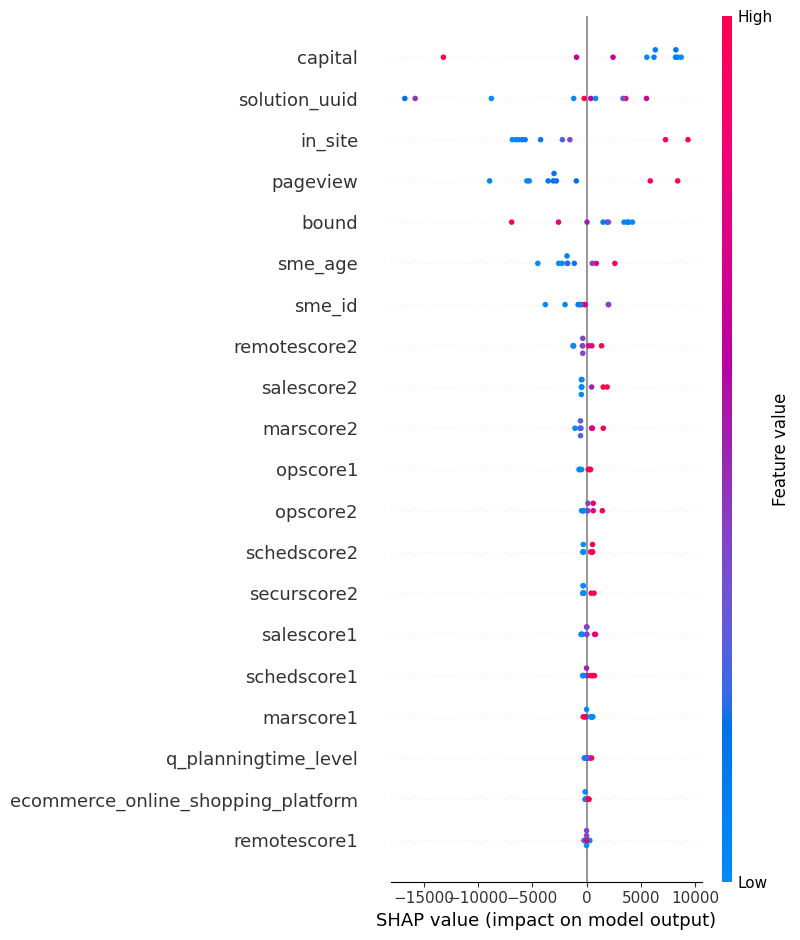

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
# 将原始特征名称与 sme_id 和 solution_uuid 组合
feature_names = ['sme_id'] + train_sme_ban_features.columns.tolist() + ['solution_uuid'] + train_solution_uuid_features.columns.tolist()
shap_values_test_combined = np.hstack(shap_values_test)
# 画 SHAP 值的 summary plot
shap.summary_plot(shap_values_test_combined, test_samples, feature_names=feature_names)

# 保存图片
plt.savefig('shap_summary_plot.png')


In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], test_sample[0], feature_names=feature_names)
plt.savefig('shap_force_plot.png')

<Figure size 640x480 with 0 Axes>

針對前五個推薦的summary


  0%|          | 0/1 [00:00<?, ?it/s]

I0514 15:25:41.883511 20470 _kernel.py:327] num_full_subsets = 1
I0514 15:25:41.885275 20470 _kernel.py:338] remaining_weight_vector = [0.13542938 0.09167527 0.06983077 0.05675136 0.04805559 0.04186576
 0.03724308 0.03366606 0.03082186 0.02851145 0.0266022  0.02500235
 0.0236464  0.02248639 0.02148639 0.02061901 0.01986298 0.01920159
 0.01862154 0.01811214 0.0176647  0.01727215 0.01692867 0.01662947
 0.01637058 0.01614876 0.01596132 0.01580608 0.0156813  0.0155856
 0.01551795 0.01547764 0.01546425]
I0514 15:25:41.886190 20470 _kernel.py:339] num_paired_subset_sizes = 33
I0514 15:25:42.019140 20470 _kernel.py:378] weight_left = 0.7880871385510887
I0514 15:26:43.212679 20470 _kernel.py:549] np.sum(w_aug) = 68.0
I0514 15:26:43.214119 20470 _kernel.py:550] np.sum(self.kernelWeights) = 1.0
W0514 15:26:43.217369 20470 warnings.py:110] The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler

  0%|          | 0/1 [00:00<?, ?it/s]

I0514 15:26:44.539423 20470 _kernel.py:327] num_full_subsets = 1
I0514 15:26:44.541380 20470 _kernel.py:338] remaining_weight_vector = [0.13542938 0.09167527 0.06983077 0.05675136 0.04805559 0.04186576
 0.03724308 0.03366606 0.03082186 0.02851145 0.0266022  0.02500235
 0.0236464  0.02248639 0.02148639 0.02061901 0.01986298 0.01920159
 0.01862154 0.01811214 0.0176647  0.01727215 0.01692867 0.01662947
 0.01637058 0.01614876 0.01596132 0.01580608 0.0156813  0.0155856
 0.01551795 0.01547764 0.01546425]
I0514 15:26:44.542622 20470 _kernel.py:339] num_paired_subset_sizes = 33
I0514 15:26:44.671554 20470 _kernel.py:378] weight_left = 0.7880871385510887
I0514 15:27:44.545972 20470 _kernel.py:549] np.sum(w_aug) = 68.0
I0514 15:27:44.547355 20470 _kernel.py:550] np.sum(self.kernelWeights) = 1.0
W0514 15:27:44.553908 20470 warnings.py:110] The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler

  0%|          | 0/1 [00:00<?, ?it/s]

I0514 15:27:45.872037 20470 _kernel.py:327] num_full_subsets = 1
I0514 15:27:45.873988 20470 _kernel.py:338] remaining_weight_vector = [0.13542938 0.09167527 0.06983077 0.05675136 0.04805559 0.04186576
 0.03724308 0.03366606 0.03082186 0.02851145 0.0266022  0.02500235
 0.0236464  0.02248639 0.02148639 0.02061901 0.01986298 0.01920159
 0.01862154 0.01811214 0.0176647  0.01727215 0.01692867 0.01662947
 0.01637058 0.01614876 0.01596132 0.01580608 0.0156813  0.0155856
 0.01551795 0.01547764 0.01546425]
I0514 15:27:45.875075 20470 _kernel.py:339] num_paired_subset_sizes = 33
I0514 15:27:46.003410 20470 _kernel.py:378] weight_left = 0.7880871385510887
I0514 15:28:46.561016 20470 _kernel.py:549] np.sum(w_aug) = 68.0
I0514 15:28:46.562386 20470 _kernel.py:550] np.sum(self.kernelWeights) = 1.0
W0514 15:28:46.565478 20470 warnings.py:110] The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler

  0%|          | 0/1 [00:00<?, ?it/s]

I0514 15:28:47.875686 20470 _kernel.py:327] num_full_subsets = 1
I0514 15:28:47.877643 20470 _kernel.py:338] remaining_weight_vector = [0.13542938 0.09167527 0.06983077 0.05675136 0.04805559 0.04186576
 0.03724308 0.03366606 0.03082186 0.02851145 0.0266022  0.02500235
 0.0236464  0.02248639 0.02148639 0.02061901 0.01986298 0.01920159
 0.01862154 0.01811214 0.0176647  0.01727215 0.01692867 0.01662947
 0.01637058 0.01614876 0.01596132 0.01580608 0.0156813  0.0155856
 0.01551795 0.01547764 0.01546425]
I0514 15:28:47.878834 20470 _kernel.py:339] num_paired_subset_sizes = 33
I0514 15:28:48.007690 20470 _kernel.py:378] weight_left = 0.7880871385510887
I0514 15:29:49.571887 20470 _kernel.py:549] np.sum(w_aug) = 68.0
I0514 15:29:49.573245 20470 _kernel.py:550] np.sum(self.kernelWeights) = 1.0
W0514 15:29:49.576552 20470 warnings.py:110] The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler

  0%|          | 0/1 [00:00<?, ?it/s]

I0514 15:29:50.887485 20470 _kernel.py:327] num_full_subsets = 1
I0514 15:29:50.889228 20470 _kernel.py:338] remaining_weight_vector = [0.13542938 0.09167527 0.06983077 0.05675136 0.04805559 0.04186576
 0.03724308 0.03366606 0.03082186 0.02851145 0.0266022  0.02500235
 0.0236464  0.02248639 0.02148639 0.02061901 0.01986298 0.01920159
 0.01862154 0.01811214 0.0176647  0.01727215 0.01692867 0.01662947
 0.01637058 0.01614876 0.01596132 0.01580608 0.0156813  0.0155856
 0.01551795 0.01547764 0.01546425]
I0514 15:29:50.890207 20470 _kernel.py:339] num_paired_subset_sizes = 33
I0514 15:29:51.023080 20470 _kernel.py:378] weight_left = 0.7880871385510887
I0514 15:30:51.547225 20470 _kernel.py:549] np.sum(w_aug) = 67.99999999999999
I0514 15:30:51.548628 20470 _kernel.py:550] np.sum(self.kernelWeights) = 1.0
W0514 15:30:51.551983 20470 warnings.py:110] The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a S

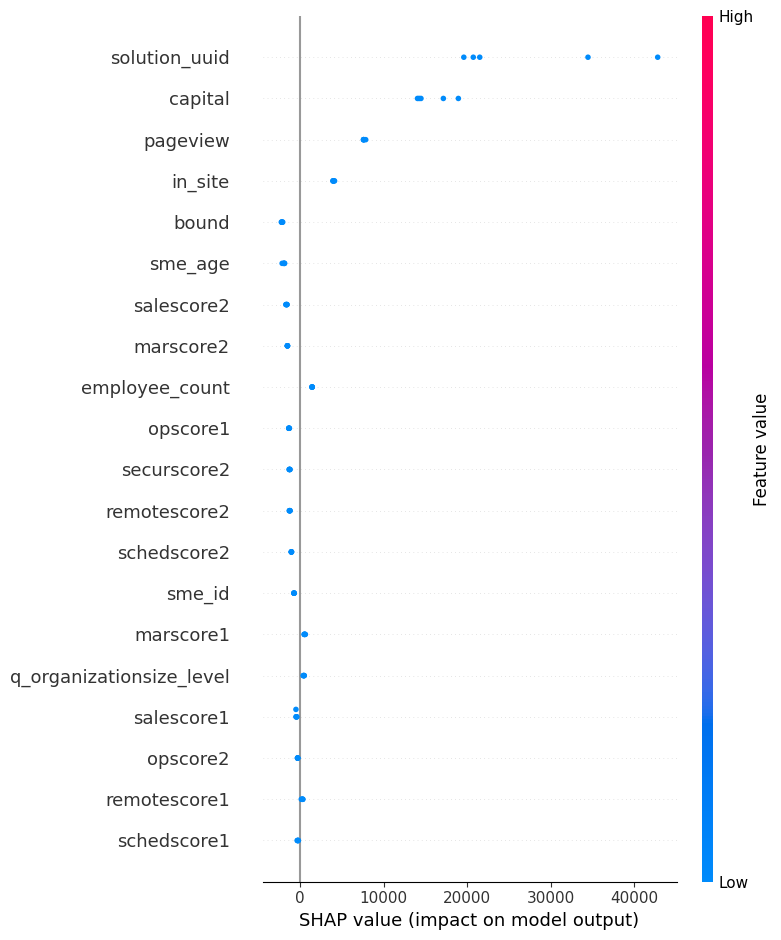

程式碼執行時間: 311.68 秒


In [26]:
# 在您的程式碼開始之前獲取當前時間
start_time = time.time()
shap_values_top5 = []
for i in range(5):  # 遍历前五名推荐结果
    encoded_solution_uuid = np.array([top5_encoded.iloc[i]])
    encoded_solution_uuid_features = on_shelf_solution_uuid_features.loc[[encoded_solution_uuid[0]]]
    
    sample = np.hstack([new_user_input.reshape(-1, 1),
                        new_user_features_input,
                        encoded_solution_uuid.reshape(-1, 1),
                        encoded_solution_uuid_features.values])
    
    shap_values = explainer.shap_values(sample)
    shap_values_top5.append(shap_values[0])

shap_values_combined = np.vstack(shap_values_top5)
shap.summary_plot(shap_values_combined, np.vstack([sample for _ in range(5)]), feature_names=feature_names)
# 程式碼結束後獲取當前時間
end_time = time.time()

# 計算並打印執行時間
execution_time = end_time - start_time
print("程式碼執行時間: {:.2f} 秒".format(execution_time))

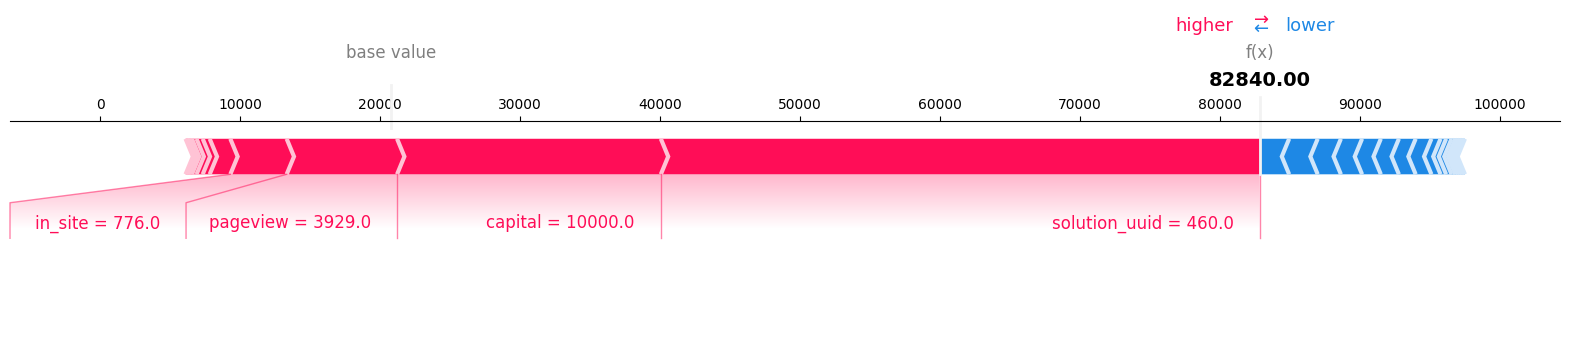

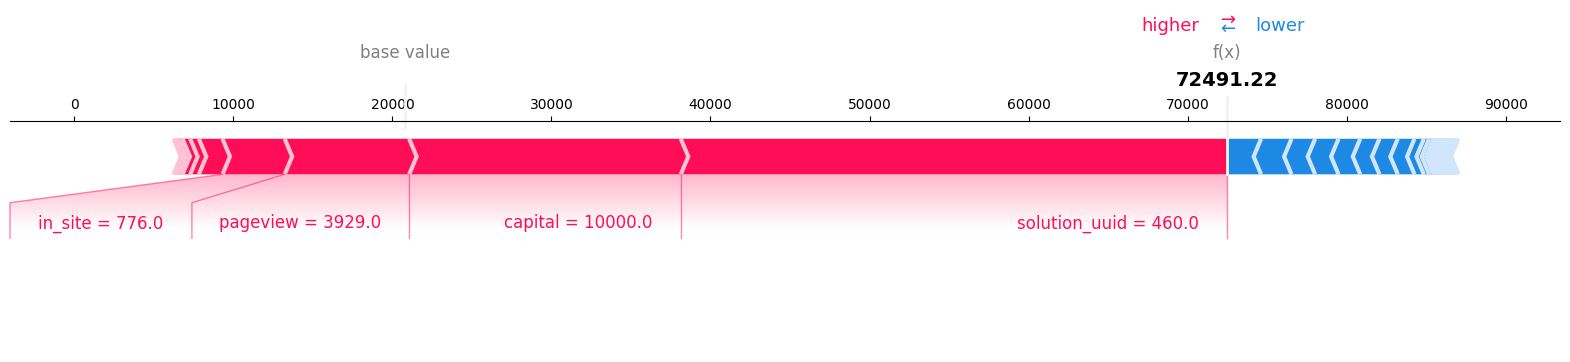

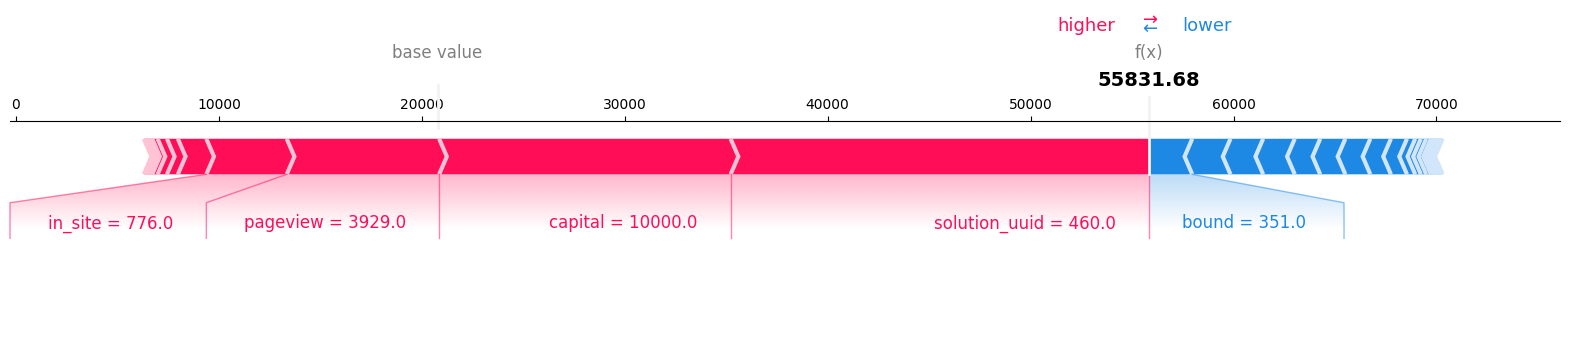

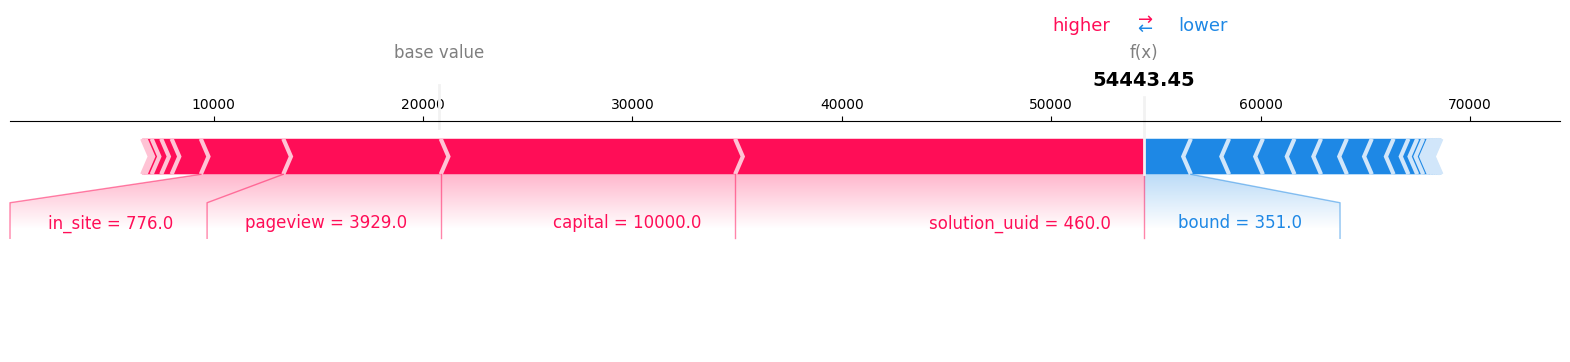

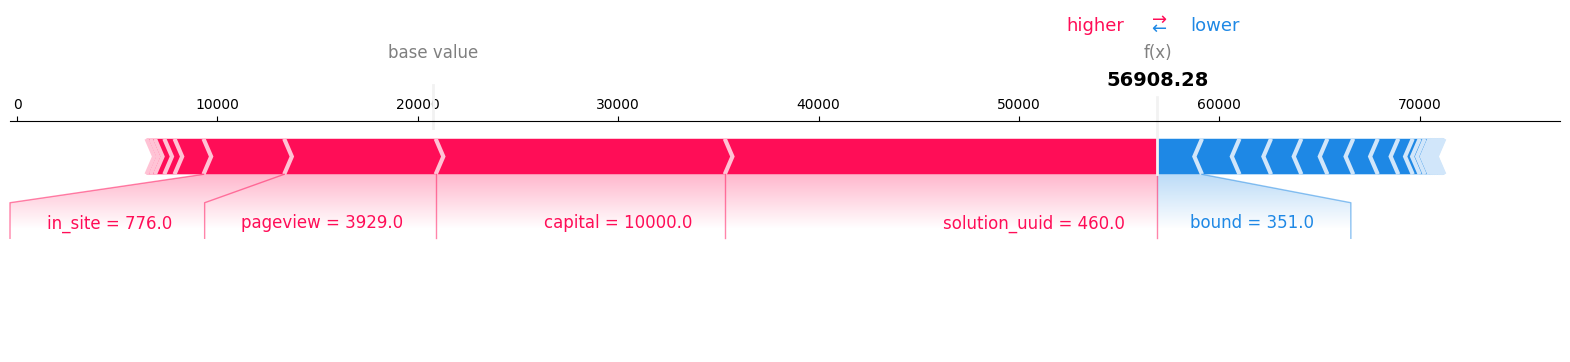

In [25]:
import matplotlib.pyplot as plt

# 对五个预测实例进行迭代
for i in range(5):
    # 生成 force_plot
    plot = shap.force_plot(explainer.expected_value, shap_values_top5[i], sample, feature_names=feature_names, matplotlib=True)

    # 保存 force_plot 为 PNG 图像
    plt.savefig(f'force_plot_{i + 1}.png', bbox_inches='tight')
    plt.close()


In [27]:
shap_values_top5

[array([[ -733.36836982,   439.10593124,   142.74123131,  -211.71614379,
         -1287.82366609,  -263.79095348,   648.12317742, -1502.02021178,
          -484.24487609, -1684.17023476,     0.        , -1244.79843571,
           249.03187632, -1285.38700099,  -223.82172985, -1046.04529351,
         -2135.36409762, 18939.84734386,  1471.8156405 ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,  -185.94977865,     0.        ,     0.        ,
             0.        ,     0.        ,   176.99303906,     0.        ,
             0.        ,  -135.22030594,     0.        ,     0.        ,
             0.        , 42776.94551848,  7859.47323813, -2064.0334794 ,
          4133.4617201 ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.    

In [28]:
print(shap_values_combined[0])
print(np.vstack([sample for _ in range(5)]) [0])
print(feature_names)

[ -733.36836982   439.10593124   142.74123131  -211.71614379
 -1287.82366609  -263.79095348   648.12317742 -1502.02021178
  -484.24487609 -1684.17023476     0.         -1244.79843571
   249.03187632 -1285.38700099  -223.82172985 -1046.04529351
 -2135.36409762 18939.84734386  1471.8156405      0.
     0.             0.             0.             0.
     0.          -185.94977865     0.             0.
     0.             0.           176.99303906     0.
     0.          -135.22030594     0.             0.
     0.         42776.94551848  7859.47323813 -2064.0334794
  4133.4617201      0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.          -103.37632245
     0.             0.             0.             0.
     0.             0.          -181.66061629     0.

In [70]:
import numpy as np

# 將 shap_values_top5 內的數據取平均
shap_values_mean = np.mean(shap_values_top5, axis=0)[0]

# 從平均後的 SHAP 值中找出正面影響的部分，並將其排序取得最大的前五個索引
positive_indices = np.argsort(shap_values_mean[shap_values_mean > 0])[-5:]

# 獲得這五個索引對應的特徵名稱
top_feats_names = np.array(feature_names)[positive_indices]

# 根據你的需求格式化輸出
print("我們推薦給您的原因是您的以下變數符合推薦：")
for name in top_feats_names:
    print(f"- {name}")


我們推薦給您的原因是您的以下變數符合推薦：
- opscore2
- salescore2
- salescore1
- opscore1
- marscore2


我們可以根據 SHAP 值來解釋影響這個推薦的主要因素。根據您提供的數據，我們可以從 SHAP 值中找出正面和負面影響的最重要因素。以下是一個簡化的解釋：

正面影響因素：






1.   資本（Capital）：您的公司具有較高的資本，這使我們認為此產品可能更適合您的需求。

2.   員工人數（Employee Count）：您擁有較多員工，我們認為這款產品有助於滿足您的業務需求。
3. 頁面瀏覽量（Pageview）：該產品的瀏覽量較高，這表明該產品受到了大量用戶的關注，可能更有潛力滿足您的需求。
4. 區域內網站使用者數量（In_site）：該產品的相關頁面有較多用戶進站，這表明該產品受到了一定程度的用戶關注。


負面影響因素：
1. 您的 SME 年齡（SME Age）：您的企業相對較年輕，這可能使某些功能對您的業務來說並非必要。
2. 遠程評分 2（Remotescore2）：您對遠程辦公的期望評分較低，可能意味著您對該產品的某些功能沒有很強的需求。

根据SHAP值分析，以下是推荐产品的主要原因：

正面影响：

本產品在網站上的總瀏覽量（Pageview）相對較高，代表許多人對這個產品感興趣。
該產品在您所屬的行業（ind_large_S）具有相對較高的影響力。
负面影响：

本產品的銷售表現（salescore2）相對較低，這可能意味著其在市場上的競爭力不強。
本產品在安全方面的評分（securscore2）相對較低，這可能影響了產品的可靠性和安全性。
進入該網站的使用者總數（In_site）相對較低，表示該產品的受眾範圍可能有限。
綜上所述，本產品在網站瀏覽量和特定行業的影響力方面具有優勢，但在銷售表現、安全評分和使用者總數方面存在劣勢。您可以根據這些因素來判斷該產品是否符合您的需求。

模型驗證

In [29]:
test_sme_ban_expanded = np.expand_dims(test_sme_ban, axis=1)
test_solution_uuid_expanded = np.expand_dims(test_solution_uuid, axis=1)

# 轉換為 NumPy 陣列
test_sme_ban_features_np = test_sme_ban_features.values
test_solution_uuid_features_np = test_solution_uuid_features.values

# 現在用擴展後的數據進行預測
test_predictions = model.predict([test_sme_ban_expanded, test_sme_ban_features_np, test_solution_uuid_expanded, test_solution_uuid_features_np])

In [56]:
test_sme_ban_expanded

array([[ 2983],
       [22312],
       [ 3174],
       ...,
       [30435],
       [24773],
       [ 9605]], dtype=int32)

In [30]:
# 計算 RMSE 和 MAE
rmse = np.sqrt(mean_squared_error(test_interactions, test_predictions))
mae = mean_absolute_error(test_interactions, test_predictions)

In [31]:
def precision_at_k(y_true, y_pred, k):
    assert len(y_true) == len(y_pred)
    n = len(y_true)
    
    precisions = []
    for i in range(n):
        top_k_indices = np.argsort(y_pred[i])[-k:]
        true_positives = sum(y_true[i, j] for j in top_k_indices if y_true[i, j] > 0)
        precisions.append(true_positives / k)
        
    return np.mean(precisions)

def recall_at_k(y_true, y_pred, k):
    assert len(y_true) == len(y_pred)
    n = len(y_true)
    
    recalls = []
    for i in range(n):
        top_k_indices = np.argsort(y_pred[i])[-k:]
        true_positives = sum(y_true[i, j] for j in top_k_indices if y_true[i, j] > 0)
        num_relevant_items = sum(y_true[i] > 0)
        recalls.append(true_positives / num_relevant_items)
        
    return np.mean(recalls)


In [32]:
# 获取测试数据的预测
test_predictions = model.predict([test_sme_ban, test_sme_ban_features, test_solution_uuid, test_solution_uuid_features])
# 整理预测结果和实际交互数据，使其适合传递给 precision_at_k 和 recall_at_k 函数
y_true = test_interactions.to_numpy()
y_pred = test_predictions
k = 5  # 设定 k 值
precision = precision_at_k(y_true, y_pred, k)
recall = recall_at_k(y_true, y_pred, k)


In [33]:
print(f"NCF RMSE:", rmse)
print(f"NCF MAE:", mae)
print(f"NCF Precision@{k}: {precision}")
print(f"NCF Recall@{k}: {recall}")


NCF RMSE: 32080.297482138678
NCF MAE: 18764.973131744515
NCF Precision@5: 7027.978102503493
NCF Recall@5: 35139.89051251746


Baseline: 矩陣分解

In [34]:
import numpy as np
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import KNNBasic, SVD

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
def get_y_true_and_y_pred(model, testset):
    y_true = np.array([rating for _, _, rating in testset])
    y_pred = np.array([model.predict(str(user), str(item), verbose=False).est for user, item, _ in testset])
    return y_true, y_pred
def precision_at_k(y_true, y_pred, k):
    n = len(y_true)
    top_k_indices = np.argsort(y_pred)[-k:]
    true_positives = sum(y_true[j] > 0 for j in top_k_indices)
    return true_positives / k

def recall_at_k(y_true, y_pred, k):
    n = len(y_true)
    top_k_indices = np.argsort(y_pred)[-k:]
    true_positives = sum(y_true[j] > 0 for j in top_k_indices)
    num_relevant_items = sum(y_true > 0)
    return true_positives / num_relevant_items


In [35]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_data[['sme_ban', 'solution_uuid', 'total_pay']], reader)

In [36]:
# 在您的程式碼開始之前獲取當前時間
start_time = time.time()

svd = SVD()
cv_results_svd = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

# 程式碼結束後獲取當前時間
end_time = time.time()

# 計算並打印執行時間
execution_time = end_time - start_time
print("程式碼執行時間: {:.2f} 秒".format(execution_time))


Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    42826.977442580.868043610.189242670.812343240.740442985.9175385.5563
Fit time          1.89    1.87    1.89    1.88    1.90    1.89    0.01    
Test time         0.04    0.04    0.04    0.04    0.04    0.04    0.00    
程式碼執行時間: 10.23 秒


In [37]:
from surprise import accuracy, Prediction

def evaluate(model, data, k=5):
    kf = KFold(n_splits=5)
    rmses, maes, precisions, recalls = [], [], [], []
    
    for trainset, testset in kf.split(data):
        model.fit(trainset)
        y_true, y_pred = get_y_true_and_y_pred(model, testset)
        predictions = [Prediction(uid=str(u), iid=str(i), r_ui=t, est=p, details={'was_impossible': False}) for (u, i, t), p in zip(testset, y_pred)]
        rmses.append(rmse(y_true, y_pred))
        maes.append(accuracy.mae(predictions, verbose=False))
        precisions.append(precision_at_k(y_true, y_pred, k))
        recalls.append(recall_at_k(y_true, y_pred, k))
        
    return np.mean(rmses), np.mean(maes), np.mean(precisions), np.mean(recalls)


In [38]:
from surprise.model_selection import train_test_split

# 将数据集划分为训练集和测试集
trainset, testset = train_test_split(data, test_size=0.2)

# 训练模型
svd.fit(trainset)

# 获取真实和预测的评分
y_true, y_pred = get_y_true_and_y_pred(svd, testset)

# 计算评价指标
svd_rmse = rmse(y_true, y_pred)
svd_mae = accuracy.mae([Prediction(uid=str(u), iid=str(i), r_ui=t, est=p, details={'was_impossible': False}) for (u, i, t), p in zip(testset, y_pred)], verbose=False)
svd_precision = precision_at_k(y_true, y_pred, 5)
svd_recall = recall_at_k(y_true, y_pred, 5)

print(f"SVD RMSE: {svd_rmse:.4f}")
print(f"SVD MAE: {svd_mae:.4f}")
print(f"SVD Precision@5: {svd_precision:.4f}")
print(f"SVD Recall@5: {svd_recall:.4f}")


SVD RMSE: 42955.1640
SVD MAE: 35020.4610
SVD Precision@5: 1.0000
SVD Recall@5: 0.0007


Content-based

In [42]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
start_time = time.time()
def content_based_model(train_user_features, train_item_features, train_interactions):
    model = LinearRegression()
    train_features = np.hstack((train_user_features, train_item_features))
    model.fit(train_features, train_interactions)
    return model

def evaluate_content_based_model(model, test_user_features, test_item_features, test_interactions):
    test_features = np.hstack((test_user_features, test_item_features))
    predictions = model.predict(test_features)
    rmse = np.sqrt(mean_squared_error(test_interactions, predictions))
    mae = mean_absolute_error(test_interactions, predictions)
    return rmse, mae, predictions

def precision_recall_at_k(test_interactions, predictions, k):
    user_count = len(test_interactions)
    precisions = []
    recalls = []

    for user_idx in range(user_count):
        true_positives = 0
        user_interactions = test_interactions[user_idx]
        user_predicted_interactions = predictions[user_idx]
        top_k_indices = np.argsort(user_predicted_interactions)[-k:]
        relevant_items = np.nonzero(user_interactions)[0]

        for index in top_k_indices:
            if index in relevant_items:
                true_positives += 1

        precision = true_positives / k
        recall = true_positives / len(relevant_items)
        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse_scores = []
mae_scores = []
precision_scores = []
recall_scores = []

for train_indices, test_indices in kf.split(recommend_encoded):
    train_data_fold = recommend_encoded.iloc[train_indices]
    test_data_fold = recommend_encoded.iloc[test_indices]

    train_sme_ban_features_fold = train_data_fold[sme_ban_columns].values
    train_solution_uuid_features_fold = train_data_fold[solution_uuid_columns].values
    train_interactions_fold = train_data_fold['total_pay'].values

    test_sme_ban_features_fold = test_data_fold[sme_ban_columns].values
    test_solution_uuid_features_fold = test_data_fold[solution_uuid_columns].values
    test_interactions_fold = test_data_fold['total_pay'].values

    model = content_based_model(train_sme_ban_features_fold, train_solution_uuid_features_fold, train_interactions_fold)
    rmse, mae, predictions = evaluate_content_based_model(model, test_sme_ban_features_fold, test_solution_uuid_features_fold, test_interactions_fold)

    precision, recall = precision_recall_at_k(test_interactions_fold, predictions, 5)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    precision_scores.append(precision)
    recall_scores.append(recall)

# 程式碼結束後獲取當前時間
end_time = time.time()

# 計算並打印執行時間
execution_time = end_time - start_time
print("程式碼執行時間: {:.2f} 秒".format(execution_time))

W0515 04:28:58.505065 20470 warnings.py:110] Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.

W0515 04:28:58.509449 20470 warnings.py:110] Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.

W0515 04:28:59.295764 20470 warnings.py:110] Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.

W0515 04:28:59.302669 20470 warnings.py:110] Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be rem

程式碼執行時間: 4.21 秒


In [40]:
content_based_rmse = np.mean(rmse_scores)
content_based_mae = np.mean(mae_scores)
content_based_precision = np.mean(precision_scores)
content_based_recall = np.mean(recall_scores)

print(f"Content-based RMSE: {content_based_rmse:.4f}")
print(f"Content-based MAE: {content_based_mae:.4f}")
print(f"Content-based Precision@5: {content_based_precision:.4f}")
print(f"Content-based Recall@5: {content_based_recall:.4f}")


Content-based RMSE: 22885.7601
Content-based MAE: 14687.0778
Content-based Precision@5: 0.2000
Content-based Recall@5: 1.0000


In [41]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(recommend_encoded, test_size=0.2, random_state=42)

train_sme_ban_features = train_data[sme_ban_columns].values
train_solution_uuid_features = train_data[solution_uuid_columns].values
train_interactions = train_data['total_pay'].values

test_sme_ban_features = test_data[sme_ban_columns].values
test_solution_uuid_features = test_data[solution_uuid_columns].values
test_interactions = test_data['total_pay'].values

model = content_based_model(train_sme_ban_features, train_solution_uuid_features, train_interactions)

rmse, mae, predictions = evaluate_content_based_model(model, test_sme_ban_features, test_solution_uuid_features, test_interactions)

precision, recall = precision_recall_at_k(test_interactions, predictions, 5)

print(f"Content-based RMSE: {rmse:.4f}")
print(f"Content-based MAE: {mae:.4f}")
print(f"Content-based Precision@5: {precision:.4f}")
print(f"Content-based Recall@5: {recall:.4f}")


W0514 15:34:39.859366 20470 warnings.py:110] Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.

W0514 15:34:39.867399 20470 warnings.py:110] Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.



Content-based RMSE: 23864.2947
Content-based MAE: 14806.5206
Content-based Precision@5: 0.2000
Content-based Recall@5: 1.0000


上線測試數據

In [ ]:
import json
import numpy as np
import pandas as pd

# 定義函數來準備輸入數據
def prepare_input_data(sme_ban, sme_ban_features, solution_uuid, solution_uuid_features):
    # 將輸入數據轉換為列表
    sme_ban = sme_ban.tolist()
    sme_ban_features = sme_ban_features.values.tolist()
    solution_uuid = solution_uuid.tolist()
    solution_uuid_features = solution_uuid_features.tolist()

    # 將輸入數據組合成一個字典
    input_data = {
        "sme_ban": sme_ban,
        "sme_ban_features": sme_ban_features,
        "solution_uuid": solution_uuid,
        "solution_uuid_features": solution_uuid_features
    }

    # 將字典轉換為 JSON 格式
    json_data = json.dumps(input_data)

    return json_data

# 假設以下是新用戶的特徵
new_user_features = pd.DataFrame([{
    'q_organizationsize_level': 3, 'q_planningtime_level': 2, 'q_budget_level': 1,
    'opscore1': 4, 'opscore2': 3, 'marscore1': 3, 'marscore2': 2, 'salescore1': 1, 'salescore2': 2,
    'securscore1': 2, 'securscore2': 3, 'remotescore1': 1, 'remotescore2': 2, 'schedscore1': 2,
    'schedscore2': 3, 'sme_age': 5, 'capital': 10000, 'employee_count': 50,
    'ind_large_A': 0, 'ind_large_B': 1, 'ind_large_C': 0, 'ind_large_D': 0,
    'ind_large_E': 0, 'ind_large_F': 0, 'ind_large_G': 0, 'ind_large_H': 0,
    'ind_large_I': 0, 'ind_large_J': 0, 'ind_large_K': 0, 'ind_large_L': 0,
    'ind_large_M': 0, 'ind_large_N': 0, 'ind_large_P': 0, 'ind_large_Q': 0,
    'ind_large_R': 0, 'ind_large_S': 0
}], columns=sme_ban_columns)

# 選擇一個物品
example_item_index = 2
example_solution_uuid = np.array([train_solution_uuid.iloc[example_item_index]])
example_solution_uuid_features = train_solution_uuid_features[example_item_index]

# 為新用戶分配一個編碼（可以選擇大於所有現有編碼的最大值的數字）
new_user_sme_ban = np.array([max(sme_ban_mapping.values()) + 1])




In [ ]:
# 假設以下是新用戶的特徵
new_user_features = pd.DataFrame([{
    'q_organizationsize_level': 1, 'q_planningtime_level': 1, 'q_budget_level': 1,
    'opscore1': 1, 'opscore2': 1, 'marscore1':1, 'marscore2': 2, 'salescore1': 1, 'salescore2': 2,
    'securscore1': 2, 'securscore2': 2 ,'remotescore1': 1, 'remotescore2': 1, 'schedscore1': 2,
    'schedscore2': 3, 'sme_age': 1, 'capital': 50000, 'employee_count': 1,
    'ind_large_A': 0, 'ind_large_B': 0, 'ind_large_C': 0, 'ind_large_D': 0,
    'ind_large_E': 0, 'ind_large_F': 0, 'ind_large_G': 0, 'ind_large_H': 0,
    'ind_large_I': 0, 'ind_large_J': 0, 'ind_large_K': 0, 'ind_large_L': 0,
    'ind_large_M': 0, 'ind_large_N': 1, 'ind_large_P': 0, 'ind_large_Q': 0,
    'ind_large_R': 0, 'ind_large_S': 0
}], columns=sme_ban_columns)
# 在這裡，我們使用所有物品進行預測
num_items = len(solution_uuid_mapping)

# 調用函數，為新用戶準備輸入數據
new_user_input, new_user_features_input = prepare_new_user_input(new_user_features, num_items)

# 選擇一個物品
example_item_index = 2
example_solution_uuid = np.array([train_solution_uuid.iloc[example_item_index]])
example_solution_uuid_features = train_solution_uuid_features.iloc[[example_item_index]]

# 使用函數為新用戶準備輸入數據
new_user_input, new_user_features_input = prepare_new_user_input(new_user_features, 1)

# 使用模型進行預測
example_output = model.predict([new_user_input, new_user_features_input, example_solution_uuid, example_solution_uuid_features])
print(f"Example output: {example_output}")


In [ ]:
def prepare_input_data(sme_ban, sme_ban_features, solution_uuid, solution_uuid_features):
    # 將輸入數據轉換為列表
    sme_ban = sme_ban.tolist()
    sme_ban_features = sme_ban_features.squeeze().tolist()  # 將張量轉換為一維張量
    solution_uuid = solution_uuid.tolist()
    solution_uuid_features = solution_uuid_features.squeeze().tolist()  # 將張量轉換為一維張量

    # 將輸入數據組合成一個字典
    input_data = {
        "instances": [
            {
                "sme_ban_input": sme_ban,
                "sme_ban_features_input": sme_ban_features,
                "solution_uuid_input": solution_uuid,
                "solution_uuid_features_input": solution_uuid_features
            }
        ]
    }

    # 將字典轉換為 JSON 格式
    json_data = json.dumps(input_data)

    return json_data

In [ ]:
# 使用函數為新用戶準備輸入數據
input_data = prepare_input_data(new_user_sme_ban, new_user_features, example_solution_uuid, example_solution_uuid_features)

# 這裡應該得到一串JSON格式的資料，然後你可以將它送入模型進行預測


In [ ]:
# 將輸入數據轉換為 JSON 格式
input_data_json = json.dumps(input_data)

# 打印 JSON 數據
print(input_data_json)


In [ ]:
input_data

In [ ]:
import json

# 使用函數為新用戶準備輸入數據
input_data = prepare_input_data(new_user_sme_ban, new_user_features, example_solution_uuid, example_solution_uuid_features)

# 將輸入數據轉換為 JSON 格式
input_data_json = json.dumps([input_data]) # 注意這裡使用了一個 list，因為你需要一個陣列

print(input_data_json)


In [ ]:
def prepare_input_data(sme_ban, sme_ban_features, solution_uuid, solution_uuid_features):
    # 將輸入數據轉換為列表
    sme_ban = sme_ban.tolist()
    sme_ban_features = sme_ban_features.values.tolist()
    solution_uuid = solution_uuid.tolist()
    solution_uuid_features = solution_uuid_features.tolist()

    # 將輸入數據組合成一個字典
    input_data = {
        "sme_ban": sme_ban,
        "sme_ban_features": sme_ban_features,
        "solution_uuid": solution_uuid,
        "solution_uuid_features": solution_uuid_features
    }

    # 將字典放到 "instances" 欄位中
    json_data = {"instances": [input_data]}

    # 將字典轉換為 JSON 格式
    json_str = json.dumps(json_data)

    return json_str

# 使用函數為新用戶準備輸入數據
input_data_json = prepare_input_data(new_user_sme_ban, new_user_features, example_solution_uuid, example_solution_uuid_features)

# 打印 JSON 數據
print(input_data_json)


In [ ]:
import numpy as np
import pandas as pd
import json

# 準備新用戶的特徵
new_user_features = pd.DataFrame([{
    'q_organizationsize_level': 1, 'q_planningtime_level': 1, 'q_budget_level': 1,
    'opscore1': 1, 'opscore2': 1, 'marscore1':1, 'marscore2': 2, 'salescore1': 1, 'salescore2': 2,
    'securscore1': 2, 'securscore2': 2 ,'remotescore1': 1, 'remotescore2': 1, 'schedscore1': 2,
    'schedscore2': 3, 'sme_age': 1, 'capital': 50000, 'employee_count': 1,
    'ind_large_A': 0, 'ind_large_B': 0, 'ind_large_C': 0, 'ind_large_D': 0,
    'ind_large_E': 0, 'ind_large_F': 0, 'ind_large_G': 0, 'ind_large_H': 0,
    'ind_large_I': 0, 'ind_large_J': 0, 'ind_large_K': 0, 'ind_large_L': 0,
    'ind_large_M': 0, 'ind_large_N': 1, 'ind_large_P': 0, 'ind_large_Q': 0,
    'ind_large_R': 0, 'ind_large_S': 0
}], columns=sme_ban_columns)


def prepare_input_data(sme_ban, sme_ban_features, solution_uuid, solution_uuid_features):
    # 將輸入數據轉換為列表
    sme_ban = sme_ban.tolist()
    sme_ban_features = sme_ban_features.tolist()  # 將張量轉換為一維張量
    solution_uuid = solution_uuid.tolist()
    solution_uuid_features = solution_uuid_features.tolist()  # 將張量轉換為一維張量

    # 將輸入數據組合成一個字典
    input_data = {
        "instances": [
            {
                "sme_ban_input": sme_ban,
                "sme_ban_features_input": sme_ban_features,
                "solution_uuid_input": solution_uuid,
                "solution_uuid_features_input": solution_uuid_features
            }
        ]
    }

    # 將字典轉換為 JSON 格式
    json_data = json.dumps(input_data)

    return json_data


# 使用所有物品進行預測
num_items = len(solution_uuid_mapping)

# 調用函數，為新用戶準備輸入數據
new_user_input, new_user_features_input = prepare_new_user_input(new_user_features, num_items)

# 選擇一個物品
example_item_index = 2
example_solution_uuid = np.array([train_solution_uuid.iloc[example_item_index]])
example_solution_uuid_features = train_solution_uuid_features.iloc[[example_item_index]]

# 使用函數為新用戶準備輸入數據
new_user_input, new_user_features_input = prepare_new_user_input(new_user_features, 1)

# 使用模型進行預測
example_output = model.predict([new_user_input, new_user_features_input, example_solution_uuid, example_solution_uuid_features])

# 將輸入數據準備為 Vertex AI 需要的格式
input_data = prepare_input_data(new_user_input, new_user_features_input, example_solution_uuid, example_solution_uuid_features)

print(input_data)


In [ ]:
import numpy as np
import pandas as pd
import json

# 假設以下是新用戶的特徵
new_user_features = pd.DataFrame([{
    'q_organizationsize_level': 1, 'q_planningtime_level': 1, 'q_budget_level': 1,
    'opscore1': 1, 'opscore2': 1, 'marscore1':1, 'marscore2': 2, 'salescore1': 1, 'salescore2': 2,
    'securscore1': 2, 'securscore2': 2 ,'remotescore1': 1, 'remotescore2': 1, 'schedscore1': 2,
    'schedscore2': 3, 'sme_age': 1, 'capital': 50000, 'employee_count': 1,
    'ind_large_A': 0, 'ind_large_B': 0, 'ind_large_C': 0, 'ind_large_D': 0,
    'ind_large_E': 0, 'ind_large_F': 0, 'ind_large_G': 0, 'ind_large_H': 0,
    'ind_large_I': 0, 'ind_large_J': 0, 'ind_large_K': 0, 'ind_large_L': 0,
    'ind_large_M': 0, 'ind_large_N': 1, 'ind_large_P': 0, 'ind_large_Q': 0,
    'ind_large_R': 0, 'ind_large_S': 0
}], columns=sme_ban_columns)

# 在這裡，我們使用所有物品進行預測
num_items = len(solution_uuid_mapping)

# 調用函數，為新用戶準備輸入數據
new_user_input, new_user_features_input = prepare_new_user_input(new_user_features, num_items)

# 選擇一個物品
example_item_index = 2
example_solution_uuid = np.array([train_solution_uuid.iloc[example_item_index]])
example_solution_uuid_features = train_solution_uuid_features.iloc[[example_item_index]]

# 使用函數為新用戶準備輸入數據
new_user_input, new_user_features_input = prepare_new_user_input(new_user_features, 1)

def prepare_input_data(sme_ban, sme_ban_features, solution_uuid, solution_uuid_features):
    # 將輸入數據轉換為列表
    sme_ban = sme_ban.tolist()
    sme_ban_features = sme_ban_features.tolist()  # 將張量轉換為一維張量
    solution_uuid = solution_uuid.tolist()
    solution_uuid_features = solution_uuid_features.values.tolist()  # 將張量轉換為一維張量

    # 將輸入數據組合成一個字典
    input_data = {
        "instances": [
            {
                "sme_ban_input": sme_ban,
                "sme_ban_features_input": sme_ban_features,
                "solution_uuid_input": solution_uuid,
                "solution_uuid_features_input": solution_uuid_features
            }
        ]
    }

    # 將字典轉換為 JSON 格式
    json_data = json.dumps(input_data)

    return json_data

# 將輸入數據準備為 Vertex AI 需要的格式
input_data = prepare_input_data(new_user_input, new_user_features_input, example_solution_uuid, example_solution_uuid_features)

print(input_data)

In [ ]:
example_solution_uuid_features

In [ ]:
example_solution_uuid